<a href="https://colab.research.google.com/github/hasabo/CW2-4070/blob/master/Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [0]:
# Cloning COCO API
!git clone https://github.com/cocodataset/cocoapi.git

Cloning into 'cocoapi'...
remote: Enumerating objects: 975, done.
remote: Total 975 (delta 0), reused 0 (delta 0), pack-reused 975
Receiving objects: 100% (975/975), 11.72 MiB | 6.41 MiB/s, done.
Resolving deltas: 100% (576/576), done.


In [0]:
# Download and unzip image annotations
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip annotations_trainval2017.zip

--2020-04-26 04:23:38--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.227.80
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.227.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  16.8MB/s    in 16s     

2020-04-26 04:23:54 (15.4 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]

Archive:  annotations_trainval2017.zip
  inflating: annotations/instances_train2017.json  
  inflating: annotations/instances_val2017.json  
  inflating: annotations/captions_train2017.json  
  inflating: annotations/captions_val2017.json  
  inflating: annotations/person_keypoints_train2017.json  
  inflating: annotations/person_keypoints_val2017.json  


In [0]:
#To interact with coco API
from pycocotools.coco import COCO
import skimage.io as io
#Common imports
import numpy as np
import pandas as pd
import os
#Visualization
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
import matplotlib.pyplot as plt 
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=10)
plt.rcParams['font.size'] = 14
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)
import seaborn as sns
#Open CV for imgage processing
import cv2
#Shuffle data splitting 
from sklearn.model_selection import StratifiedShuffleSplit
#Dimensionality reduction
from sklearn.decomposition import PCA
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False
   
# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"
from functools import partial
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import RandomizedSearchCV

# to make this notebook's output stable across runs
np.random.seed(1)
tf.random.set_seed(1)

# Print out all outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Batch Size
batch_size = 32

# GPU avalilability
gpu = tf.config.list_physical_devices('GPU')
print(f'Available GPU: {gpu}')


Available GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Data Exploration

In [0]:
# initialize COCO api for instance annotations
dataDir='.'
dataType='val2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)
coco=COCO(annFile)

loading annotations into memory...
Done (t=0.64s)
creating index...
index created!


In [0]:
# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms1 = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms1)))

COCO categories: 
person bicycle car motorcycle airplane bus train truck boat traffic light fire hydrant stop sign parking meter bench bird cat dog horse sheep cow elephant bear zebra giraffe backpack umbrella handbag tie suitcase frisbee skis snowboard sports ball kite baseball bat baseball glove skateboard surfboard tennis racket bottle wine glass cup fork knife spoon bowl banana apple sandwich orange broccoli carrot hot dog pizza donut cake chair couch potted plant bed dining table toilet tv laptop mouse remote keyboard cell phone microwave oven toaster sink refrigerator book clock vase scissors teddy bear hair drier toothbrush

COCO supercategories: 
food sports indoor kitchen furniture person animal appliance electronic accessory vehicle outdoor


In [0]:
# Query Image Ids from the annotation file
catIds = coco.getCatIds(catNms=nms)
imgIds = []
for cat in catIds:
  imgIds.append(coco.getImgIds(catIds=cat ))
# Ascending Sort for the Image IDs by category 
imgIds.sort(key = lambda l: len(l))

In [0]:
# Counting the total number of images in COCO VAL 2017
Num_images = len(set(x for l in imgIds for x in l))
print(f'Number of Images in this set = {Num_images}')

Number of Images in this set = 4952


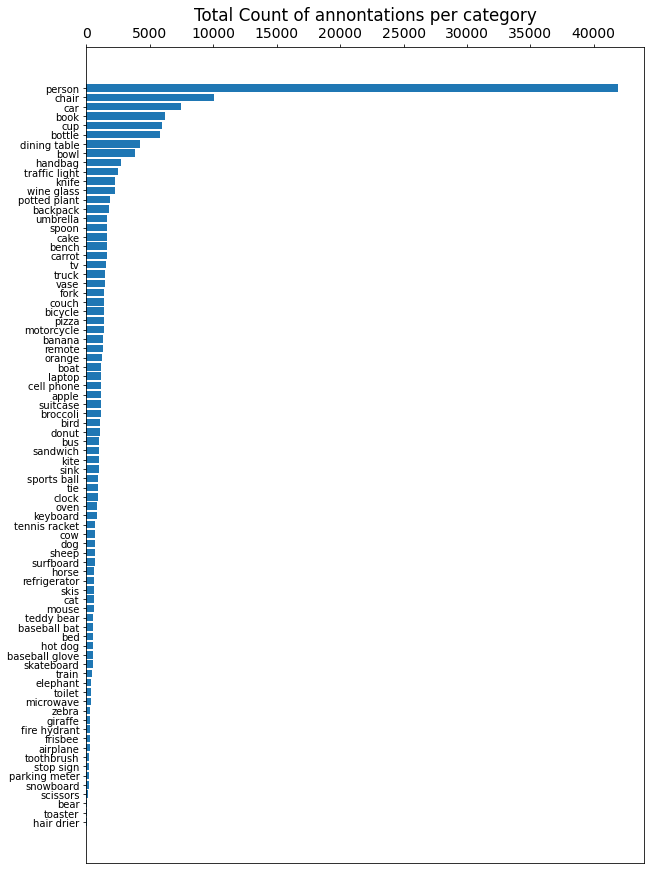

In [0]:
# Visualizing the sorted count of annotations per category
ann_cat = {}
for i in range(len(imgIds)):
    for j in range(len(imgIds[i])):
        annIds = coco.getAnnIds(imgIds=imgIds[i][j], catIds=coco.getCatIds(catIds), iscrowd=None)
        for k in range(len(annIds)):
            ct = coco.loadCats(coco.loadAnns(annIds)[k]['category_id'])[0]['name']
            if not ct in ann_cat:
                ann_cat[ct]=1
            else:
                ann_cat[ct]+=1
    
ann_cat = {k: v for k, v in sorted(ann_cat.items(), key=lambda item: item[1])}
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
fig,ax = plt.subplots(figsize=(10, 15))
ax.barh(list(ann_cat.keys()), list(ann_cat.values()))
ax.set_title('Total Count of annontations per category')
plt.show()


# Image Resizing Prepartion 

In [0]:
# Empty lists to record the width and height of the matched cropped images
w = []
h = []
# Iteration through the half the categories sorted ascendingly considering the other categories while cropping.
for i in range(int(len(imgIds)/2)):
    for j in range(len(imgIds[i])):
        annIds = coco.getAnnIds(imgIds=imgIds[i][j], catIds=coco.getCatIds(catIds), iscrowd=None)
        for k in range(len(annIds)):
            img_w = coco.loadAnns(annIds)[k]['bbox'][2]
            img_h = coco.loadAnns(annIds)[k]['bbox'][3]
            if (img_w < 1)| (img_h < 1):  
                continue
            w.append(img_w)
            h.append(img_h)

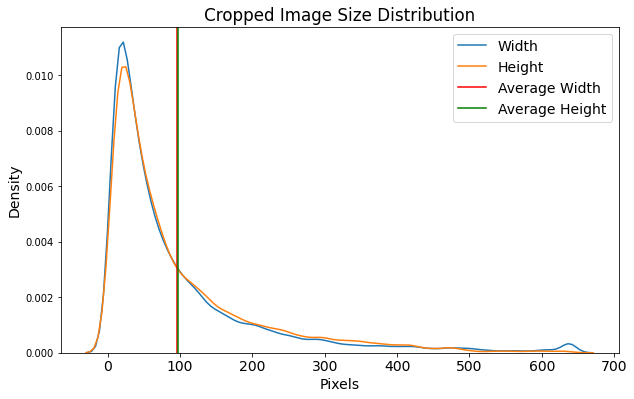

In [0]:
# Visualizing Image Size distribution
plt.figure(figsize=(10, 6))
plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = True
plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = False
sns.kdeplot(w, label='Width')
sns.kdeplot(h, label='Height')
plt.axvline(np.mean(w),color='r',label='Average Width')
plt.axvline(np.mean(h), color='g',label='Average Height')
plt.xlabel('Pixels')
plt.ylabel('Density')
plt.title('Cropped Image Size Distribution')
plt.legend()
plt.show()

# Image Acquisition and Resizing

In [0]:
# Empty lists and dictionaries for the Image features and labels
label = []
feature_dict= {}
label_dict = {}
img_list = []
# Same Iteration after selecting the resize image width and height to be the average.
for i in range(int(len(imgIds)/2)):
    for j in range(len(imgIds[i])):
        img = coco.loadImgs(imgIds[i][j])
        if img in img_list:
            continue
        else:
            I = io.imread(img[0]['coco_url'])
            annIds = coco.getAnnIds(imgIds=imgIds[i][j], catIds=coco.getCatIds(catIds), iscrowd=None)
            # consider only the RGB images
            if len(I.shape) != 3 :
                continue
            # drop the boxes without annotation
            elif annIds==[]:
                continue
            else: 
                for k in range(len(annIds)):
                    bbox = coco.loadAnns(annIds)[k]['bbox']
                    x = np.int(bbox[0])
                    y = np.int(bbox[1])
                    width = np.int(bbox[2])
                    height = np.int(bbox[3])
                    # drop the tiny images 
                    if (width < 4)| (height < 4):  
                        continue
                    elif str(imgIds[i][j])+str(k+.1) in feature_dict:
                        continue

                    else:
                        # resize the cropped image so it can be stacked after that in an array.
                        img_resized = cv2.resize(I[y:y+height,x:x+width,:], dsize=(100, 100), interpolation=cv2.INTER_CUBIC )
                        feature_dict[str(imgIds[i][j])+str(k+.1)] = img_resized
                        label.append(coco.loadAnns(annIds)[k]['bbox'])
                        label.append(coco.loadAnns(annIds)[k]['category_id'])
                        label_dict[str(imgIds[i][j])+str(k+.1)] = label
                        label = []
    

# Image Prepro 

In [0]:
# Stacking the image features in an array
X = np.array(list(feature_dict.values()),dtype = "float32")
X.shape

(20749, 100, 100, 3)

In [0]:
# Stacking the image category ids in an array
y = np.array(list(label_dict.values()))[:,1].astype("uint8")
y.shape

(20749,)

In [0]:
# Function to count the number of images per categories in a given data.
def count_category(data, new=False):
    cat = {}
    for c in list(data):
    if new:
        ct = new_catIds[c]
    else:
        ct = coco.loadCats(np.int(c))[0]['name'] 
    if not ct in cat:
        cat[ct] = 1
    else:
        cat[ct]+= 1
    return pd.DataFrame.from_dict(cat, orient='index')


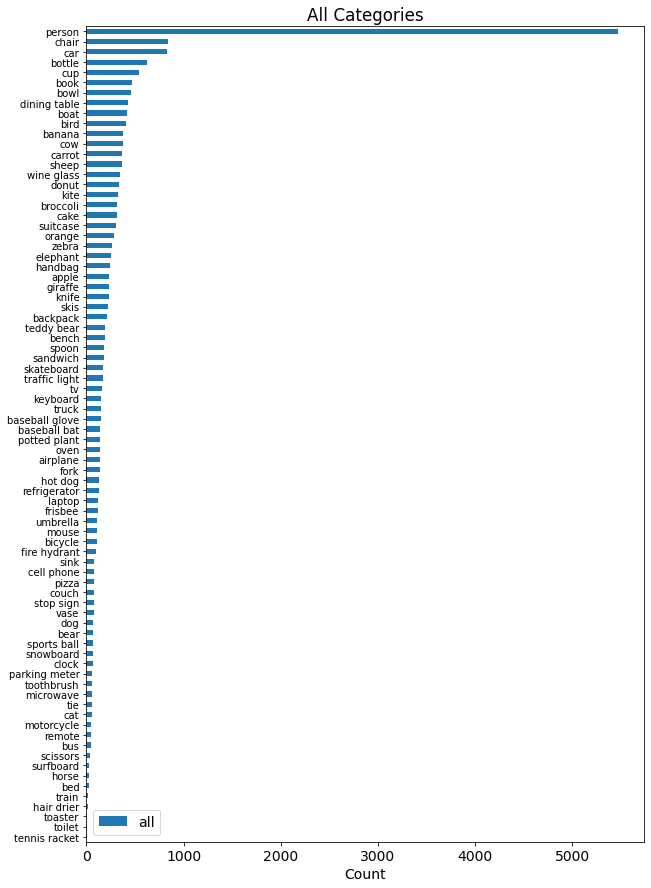

In [0]:
# Visaluizing all the retrieved categories.
c_all = count_category(y)
c_all.columns = ['all']
c_all.sort_values('all', ascending = True ).plot.barh(figsize=(10,15))
plt.xlabel('Count')
plt.title('All Categories')
plt.show()


In [0]:
#considering only the categories with more than 150 images and less than 450.
X = X[np.isin(y,np.where((np.bincount(y)>150)&(np.bincount(y)<450))[0])]
y = y[np.isin(y,np.where((np.bincount(y)>150)&(np.bincount(y)<450))[0])]
X.shape
y.shape
print(f'Number of chosen categories = {len(np.unique(y))}')

Number of chosen categories = 30


In [0]:
#mapping the selected to a sequence which is required for neural networks 
chosen_cat = list(np.unique(y))
new_catIds = {}
for i,v in enumerate (chosen_cat):
    y[y==v] = i
    new_catIds[i] = coco.loadCats(np.int(v))[0]['name']

In [0]:
# functions to display the original and cropped images
def display_image(p):
    plt.imshow(p.astype('uint8'))
    plt.axis('off')
def display_image_rect(p):
    ax = plt.gca()
    anns = coco.loadAnns(annIds)[1]['bbox']
    ax.imshow(p.astype('uint8'))
    ax.axis('off')
    rect = patches.Rectangle((anns[0],anns[1]),anns[2],anns[3],linewidth=2, edgecolor='r',facecolor='none')
    ax.add_patch(rect)


In [0]:
# function to remove gaussian noise
def blur(image, kernel):
    img_noNoise = cv2.GaussianBlur(image, (kernel, kernel), 0)
    return img_noNoise

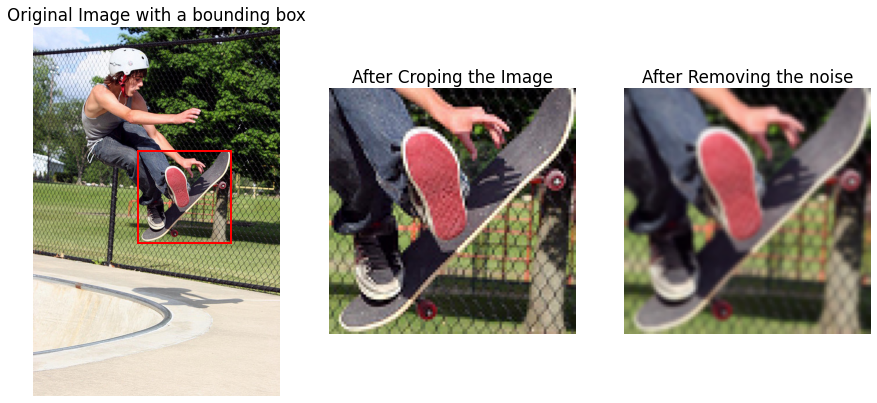

In [0]:
# Visualization for a sample of person shows the impact of gaussian blurring
plt.figure(figsize=(15,7))
plt.subplot(131)
plt.title("Original Image with a bounding box")
display_image_rect(I)
plt.subplot(132)
plt.title("After Croping the Image")
display_image(img_resized)
plt.subplot(133)
plt.title("After Removing the noise")
display_image(blur(img_resized,3))


In [0]:
# applying blurring on all images
X_blurred=np.zeros(X.shape)
for i in range(X.shape[0]):
    X_blurred[i] = blur(X[i],3)

# Machine Learning Input Preparation 

In [0]:
# splitting the full dataset into 60% training and 40% testing
split = StratifiedShuffleSplit(n_splits=1, test_size=0.4, random_state=1)
for i, j in split.split(X_blurred, y):
    X_train, y_train = X_blurred[i], y[i]
    X_test_full, y_test_full = X_blurred[j], y[j]


In [0]:
# splitting the 40% for testing  into  20% validating and 20%testing
split = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=1)
for i, j in split.split(X_test_full, y_test_full):
    X_valid, y_valid = X_test_full[i], y_test_full[i]
    X_test, y_test = X_test_full[j], y_test_full[j]

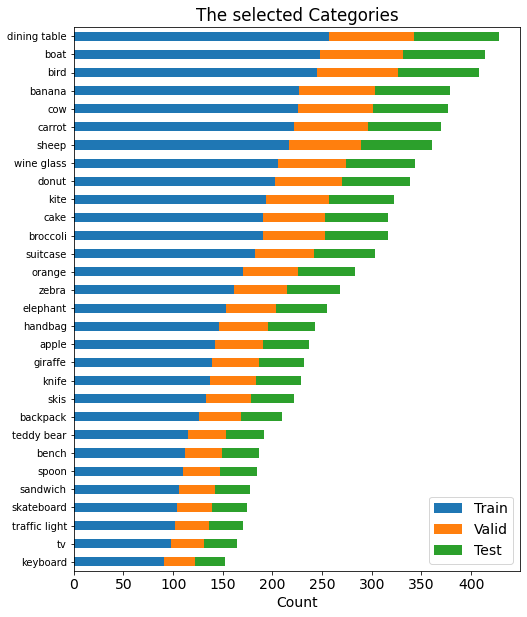

In [0]:
# Visualizing the categories with more than 50 images per category
c_train = count_category(y_train, True)
c_valid = count_category(y_valid, True)
c_test = count_category(y_test, True)
m1 = c_train.merge(c_valid, how='outer', left_index=True, right_index=True)
m2 = m1.merge(c_test, how='outer', left_index=True, right_index=True)
m2.columns = ['Train','Valid','Test']
m2.sort_values(['Train','Valid','Test'], ascending = True ).plot.barh(stacked =True,figsize=(8,10))
plt.xlabel('Count')
plt.title('The selected Categories')
plt.show()

In [0]:
# Normalizing the features
X_train = X_train/255
X_valid = X_valid/255
X_test = X_test/255

# confirming [0...1] score
np.ptp(X_train, axis = (1,2,3))

array([0.78259804, 1.        , 0.9995098 , ..., 0.92401961, 0.97916667,
       0.99019608])

In [0]:
# Reshaped Verison by unrolling the features 
r_train = np.reshape(X_train, (X_train.shape[0], 30000))
r_valid = np.reshape(X_valid, (X_valid.shape[0], 30000))
r_test = np.reshape(X_test, (X_test.shape[0], 30000))

In [0]:
# Using PCA to reduce the features dimensions for the reshaped training set 
pca = PCA(n_components=0.99)
pca_train = pca.fit_transform(r_train)

#New reduced reshaped training set dims
pca_train.shape


(4951, 1048)

In [0]:
# Using PCA to reduce the features dimensions for the reshaped testing sets
pca_valid = pca.transform(r_valid)
pca_test = pca.transform(r_test)

In [0]:
# Reconstructing the images using pca inverse
X_reconstruct = pca.inverse_transform(pca_train)

#Recontructed training set dims
X_reconstruct.shape

(4951, 30000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


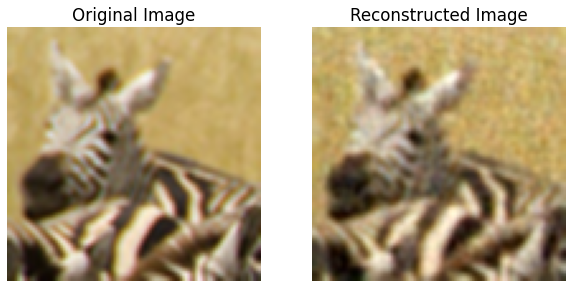

In [0]:
#Visualizing a sample reconstructed image
plt.figure(figsize=(10,5))
index = np.random.randint(X_reconstruct.shape[0])
plt.subplot(121)
plt.title("Original Image")
plt.imshow(X_train[index])
plt.axis('off')
plt.subplot(122)
plt.title("Reconstructed Image")
plt.imshow((np.reshape(X_reconstruct[index],(100, 100,3))))
plt.axis('off')
plt.show()

# Transfer Learning input preparation

In [0]:
# using tensor instead of numpy arrays
train_set_raw = tf.data.Dataset.from_tensor_slices((X_train, y_train))
valid_set_raw = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
test_set_raw = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [0]:
# Function for data augmentation and resizing the images to match the required standard size
def preprocess(image, label, flip=False):
    if flip:
        flipped_image = tf.image.random_flip_left_right(image)
        resized_image = tf.image.resize(flipped_image, [224, 224])
    else:
        resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image*255)
    return  final_image, label

<Figure size 720x360 with 0 Axes>

Text(0.5, 1.0, 'Original Image')

(-0.5, 99.5, 99.5, -0.5)

Text(0.5, 1.0, 'Flipped Image')

(-0.5, 99.5, 99.5, -0.5)

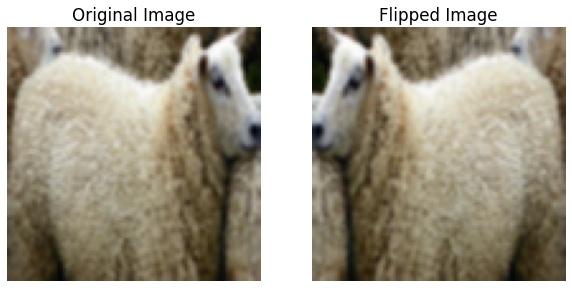

In [150]:
#Visualizing Data augmentation
plt.figure(figsize=(10,5))
index = np.random.randint(X_reconstruct.shape[0])
plt.subplot(121)
plt.title("Original Image")
plt.imshow(X_train[index])
plt.axis('off')
plt.subplot(122)
plt.title("Flipped Image")
plt.imshow(tf.image.flip_left_right(X_train[index]))
plt.axis('off')
plt.show()

In [0]:
# Using data augmentation and resizing for training set while resize only for testing sets
train_set = train_set_raw.shuffle(1000).repeat(2)
train_set = train_set.map(partial(preprocess, flip=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

# Modelling 

## Stochastic Gradient Descent Classifier




In [0]:
# Training and validating Stochastic Gradient Descent Classifier
sgd_clf = SGDClassifier (class_weight='balanced', n_jobs = -1, max_iter=10000, random_state = 1 )
sgd_clf.fit(pca_train, y_train)
y_valid_pred = sgd_clf.predict(pca_valid)
sgd_val = accuracy_score(y_valid, y_valid_pred)
print(f'\n\n\nSGD Validation Accuracy = {sgd_val}')

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=10000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
              power_t=0.5, random_state=1, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)




SGD Validation Accuracy = 0.21333333333333335


In [0]:
# Testing the Stochastic Gradient Descent Classifier
y_test_pred = sgd_clf.predict(pca_test)
sgd_test = accuracy_score(y_test, y_test_pred)
print(f'SGD Testing Accuracy = {sgd_test}')

SGD Testing Accuracy = 0.2059357964869776


## Support Vector Machine Classifier

In [0]:
# Training and validating Support Vector Machine Classifier with Gaussian Kernel
svm_clf = SVC(gamma="auto", class_weight='balanced', probability=True, random_state = 1)
svm_clf.fit(pca_train, y_train)
y_valid_pred = svm_clf.predict(pca_valid)
svm_val = accuracy_score(y_valid, y_valid_pred)
print(f'\n\n\nSVC Validation Accuracy = {svm_val}')

SVC(C=1.0, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=True, random_state=1, shrinking=True, tol=0.001,
    verbose=False)




SVC Validation Accuracy = 0.2775757575757576


In [0]:
# Testing the Support Vector Machine Classifier
y_test_pred = svm_clf.predict(pca_test)
svm_test = accuracy_score(y_test, y_test_pred)
print(f'SVC Testing Accuracy = {svm_test}')

SVC Testing Accuracy = 0.2810417928528165


## KNeighborsClassifier

In [0]:
# Training and validating KNeighborsClassifier with manual tuned n_neighbors
neigh_clf = KNeighborsClassifier(n_neighbors=11, weights='distance', n_jobs = -1)
neigh_clf.fit(pca_train, y_train)
y_valid_pred = neigh_clf.predict(pca_valid)
neigh_val = accuracy_score(y_valid, y_valid_pred)
print(f'\n\n\nKNeighborsClassifier Validation Accuracy = {neigh_val}')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=11, p=2,
                     weights='distance')




KNeighborsClassifier Validation Accuracy = 0.18848484848484848


In [0]:
# Testing the KNeighborsClassifier
y_test_pred = neigh_clf.predict(pca_test)
neigh_test = accuracy_score(y_test, y_test_pred)
print(f'KNeighborsClassifier Testing Accuracy = {neigh_test}')

KNeighborsClassifier Testing Accuracy = 0.17989097516656571


## VotingClassifier

In [0]:
# Training and validating VotingClassifier of SGD, SVC and Neigh Classifiers
named_estimators = [
    ("sgd_clf", sgd_clf),
    ("svm_clf", svm_clf),
    ("neigh_clf", neigh_clf)
]
voting_clf = VotingClassifier(named_estimators)
voting_clf.fit(pca_train, y_train)
y_valid_pred = voting_clf.predict(pca_valid)
voting_val = accuracy_score(y_valid, y_valid_pred)
print(f'\n\n\nVotingClassifier Validation Accuracy = {voting_val}')

VotingClassifier(estimators=[('sgd_clf',
                              SGDClassifier(alpha=0.0001, average=False,
                                            class_weight='balanced',
                                            early_stopping=False, epsilon=0.1,
                                            eta0=0.0, fit_intercept=True,
                                            l1_ratio=0.15,
                                            learning_rate='optimal',
                                            loss='hinge', max_iter=10000,
                                            n_iter_no_change=5, n_jobs=-1,
                                            penalty='l2', power_t=0.5,
                                            random_state=1, shuffle=True,
                                            tol=0.001, validation_fraction=0.1,
                                            ve...
                                  decision_function_shape='ovr', degree=3,
                                  gam




VotingClassifier Validation Accuracy = 0.25393939393939396


In [0]:
# Testing the VotingClassifier
y_test_pred = voting_clf.predict(pca_test)
voting_test = accuracy_score(y_test, y_test_pred)
print(f'Voting Classifier Testing Accuracy = {voting_test}')

Voting Classifier Testing Accuracy = 0.2616596002422774


## Multi-Layer Perceptron

In [0]:
# function to build neural network with same number of neurons in each hidden layer
def build_model(n_hidden=3, n_neurons=300, learning_rate=3e-3):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=[pca_train.shape[1]]))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(units=30, activation='softmax'))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model
keras_clf = keras.wrappers.scikit_learn.KerasClassifier(build_model)


In [0]:
#  Function to plot the training and validation mean and standard deviation. Also, the best 5 scores summary table.  

def plot_cross_validation_curve(cv):
    df1 = pd.DataFrame({'mean_train':cv["mean_train_score"],'std_train':cv["std_train_score"]})
    df2 = pd.DataFrame({'mean_validation':cv["mean_test_score"],'std_validation':cv["std_test_score"]})
    df3 = pd.DataFrame(cv["params"])
    c = pd.concat([df1,df2,df3],axis=1)
    c.sort_values(by=['mean_validation','mean_train'],ascending=False, inplace=True)
    c.reset_index(inplace=True)
    c = c.head(5)
    fig,ax=plt.subplots()
    ax.plot(range(5), c['mean_train'], label='train score')
    ax.fill_between(range(5), c['mean_train']-c['std_train'], c['mean_train']+c['std_train'], alpha=0.2)
    ax.plot(range(5), c['mean_validation'], label='validation score')
    ax.fill_between(range(5), c['mean_validation']-c['std_validation'], c['mean_validation']+c['std_validation'], alpha=0.2)
    ax.set_ylabel('Cross Validation Accuracy')
    ax.legend(loc='best')
    fig.tight_layout()
    plt.show()
    return ax,c

In [0]:
# Tuning the NN archeticture and Hyper parameters 
param_distribs = {
    "n_hidden": [2,3,5],
    "n_neurons": [2000,3000],
    "learning_rate": [ 3e-4, 3e-3],
}
rnd_search_cv = RandomizedSearchCV(keras_clf, param_distribs, n_iter=10,return_train_score=True,
                                                scoring='accuracy', cv=5)
rnd_search_cv.fit(pca_train, y_train, epochs=100,validation_data=(pca_valid, y_valid), 
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Best Parameters : {'n_neurons': 3000, 'n_hidden': 3, 'learning_rate': 0.003}
Best score :0.2803457379037601
52/52 [==============================] - 0s 2ms/step - loss: 2.6379 - accuracy: 0.2800
Multi-Layer Perceptron Validation Accuracy = 0.2800000011920929
52/52 [==============================] - 0s 2ms/step - loss: 2.5861 - accuracy: 0.2895
Multi-Layer Perceptron Testing Accuracy = 0.2895215153694153


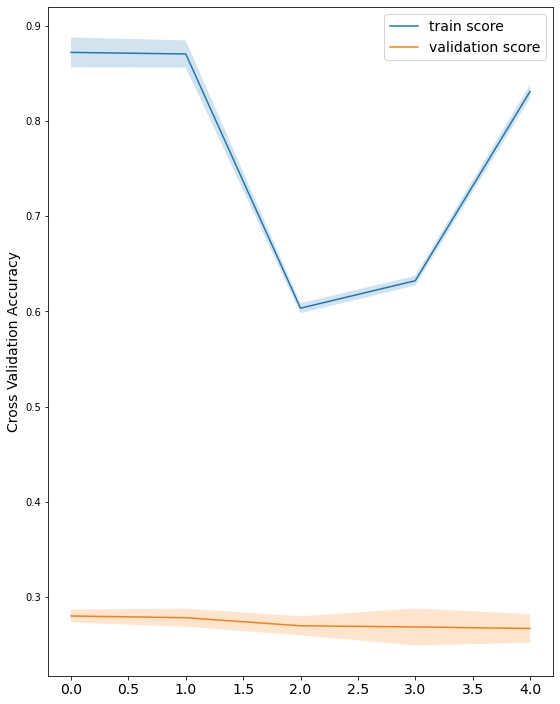

(<matplotlib.axes._subplots.AxesSubplot at 0x7fc7f6c404e0>,
    index  mean_train  std_train  ...  n_neurons  n_hidden  learning_rate
 0      9    0.871997   0.015693  ...       3000         3         0.0030
 1      7    0.870330   0.014231  ...       3000         2         0.0030
 2      1    0.603464   0.005252  ...       3000         3         0.0003
 3      4    0.632296   0.005099  ...       3000         2         0.0003
 4      5    0.830944   0.007142  ...       2000         2         0.0030
 
 [5 rows x 8 columns])

In [0]:
# MLP Evaluation 
print(f'Best Parameters : {rnd_search_cv.best_params_}')
print(f'Best score :{rnd_search_cv.best_score_}')
mlp_clf = rnd_search_cv.best_estimator_.model
mlp_clf_results= rnd_search_cv.cv_results_
mlp_val = mlp_clf.evaluate(pca_valid, y_valid)[1]
print(f'Multi-Layer Perceptron Validation Accuracy = {mlp_val}')
mlp_test = mlp_clf.evaluate(pca_test, y_test)[1]
print(f'Multi-Layer Perceptron Testing Accuracy = {mlp_test}')
plot_cross_validation_curve(mlp_clf_results)


## Convolutional Neural Network : Xception 

In [0]:
keras.backend.clear_session()

In [0]:
# dir to save tensorboard logs
root_logdir = os.path.join(os.curdir, "my_logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'./my_logs/run_2020_04_26-05_47_20'

In [0]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
# take the average of each feature map for dimensionality reduction 
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
# softmax class probability layer with the chosen 30 categories
output = keras.layers.Dense(30, activation="softmax")(avg)
# combining the base model and the customized top layers 
model = keras.models.Model(inputs=base_model.input, outputs=output)

83689472/83683744 [==============================] - 1s 0us/step


In [0]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

In [0]:
# freeze the weights of the pre trained layers
for layer in base_model.layers:
    layer.trainable = False
# training the top layers
optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, epochs=10, validation_data=valid_set)
score = model.evaluate(test_set)


Epoch 1/10
310/310 [==============================] - 28s 90ms/step - loss: 1.4167 - accuracy: 0.6814 - val_loss: 1.3344 - val_accuracy: 0.6782
Epoch 2/10
310/310 [==============================] - 27s 87ms/step - loss: 0.3641 - accuracy: 0.8904 - val_loss: 1.2361 - val_accuracy: 0.6939
Epoch 3/10
310/310 [==============================] - 27s 87ms/step - loss: 0.2272 - accuracy: 0.9416 - val_loss: 1.2097 - val_accuracy: 0.6952
Epoch 4/10
310/310 [==============================] - 27s 87ms/step - loss: 0.1820 - accuracy: 0.9601 - val_loss: 1.1930 - val_accuracy: 0.6964
Epoch 5/10
310/310 [==============================] - 27s 87ms/step - loss: 0.1585 - accuracy: 0.9692 - val_loss: 1.1934 - val_accuracy: 0.6976
Epoch 6/10
310/310 [==============================] - 27s 87ms/step - loss: 0.1463 - accuracy: 0.9747 - val_loss: 1.1944 - val_accuracy: 0.6933
Epoch 7/10
310/310 [==============================] - 27s 87ms/step - loss: 0.1349 - accuracy: 0.9793 - val_loss: 1.1920 - val_accuracy:

In [0]:
# unfreeze the weights of the pre trained layers
for layer in base_model.layers:
    layer.trainable = True
# training the whole layers
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
# save best performance on the validation set
checkpoint_cb = keras.callbacks.ModelCheckpoint("Hasabo_model.h5", save_best_only=True)
# interrupt the training when there is no progress on the validation set for 10 epocs
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)
#view the learning curves during training using tensorboard
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(train_set, epochs=100, validation_data=valid_set, callbacks=[checkpoint_cb,early_stopping_cb,tensorboard_cb])

Epoch 1/100
310/310 [==============================] - 117s 378ms/step - loss: 0.7050 - accuracy: 0.7880 - val_loss: 1.1288 - val_accuracy: 0.6915
Epoch 2/100
310/310 [==============================] - 116s 374ms/step - loss: 0.1305 - accuracy: 0.9601 - val_loss: 1.0224 - val_accuracy: 0.7497
Epoch 3/100
310/310 [==============================] - 116s 374ms/step - loss: 0.0398 - accuracy: 0.9893 - val_loss: 0.9971 - val_accuracy: 0.7600
Epoch 4/100
310/310 [==============================] - 116s 374ms/step - loss: 0.0189 - accuracy: 0.9966 - val_loss: 0.9911 - val_accuracy: 0.7733
Epoch 5/100
310/310 [==============================] - 115s 371ms/step - loss: 0.0105 - accuracy: 0.9984 - val_loss: 1.0057 - val_accuracy: 0.7697
Epoch 6/100
310/310 [==============================] - 115s 372ms/step - loss: 0.0090 - accuracy: 0.9988 - val_loss: 1.0023 - val_accuracy: 0.7727
Epoch 7/100
310/310 [==============================] - 115s 371ms/step - loss: 0.0052 - accuracy: 0.9997 - val_loss: 1

In [0]:
xception_val = model.evaluate(valid_set)[1]

52/52 [==============================] - 4s 72ms/step - loss: 0.9911 - accuracy: 0.7733


In [0]:
xception_test = model.evaluate(test_set)[1]

52/52 [==============================] - 4s 72ms/step - loss: 0.9730 - accuracy: 0.7704


In [0]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

<IPython.core.display.Javascript object>

In [0]:
# saving the best model 
model = keras.models.load_model("Hasabo_model.h5")

In [0]:
# The layers of the best model 
for index, layer in enumerate(model.layers):
    print(index, layer.name)

# Performance Comparison 

In [0]:
# Performance Comparison 
valid_accuracy = [sgd_val,neigh_val,svm_val,voting_val,mlp_val,xception_val]
test_accuracy = [sgd_test,neigh_test,svm_test,voting_test,mlp_test,xception_test]
index = ['SGD','KNN','SVM','Voting','MLP','Xception']
accuracy_df = pd.DataFrame({'Validation Accuracy':valid_accuracy,'Test Accuracy':test_accuracy},index=index)
accuracy_df

Validation Accuracy  Test Accuracy
SGD                  0.213333       0.205936
KNN                  0.188485       0.179891
SVM                  0.277576       0.281042
Voting               0.253939       0.261660
MLP                  0.280000       0.289522
Xception             0.773333       0.770442

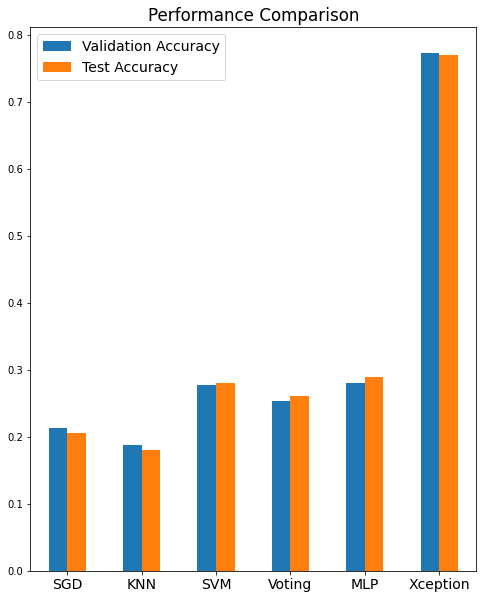

In [0]:
accuracy_df.plot.bar(rot=0, title = 'Performance Comparison')